<h3>Importing Libraries</h3>

In [1]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

<h3>Creating dummy dataset</h3>

In [2]:
# Dummy Dataset
np.random.seed(42)
n = 2000

age = np.random.randint(21, 70, size=n)
income = np.round(np.random.normal(60000, 25000, size=n)).clip(8000, 300000)
loan_amount = np.round(np.random.normal(15000, 10000, size=n)).clip(1000, 100000)
loan_term_month = np.random.choice([12, 24, 36, 48, 60], size=n, p=[0.05, 0.15, 0.4, 0.25, 0.15])
credit_score = np.round(np.random.normal(650, 70, size=n)).clip(300, 850)
employment_years = np.round(np.random.exponential(scale=3, size=n)).astype(int)
prior_defaults = np.random.choice([0, 1], size=n, p=[0.9, 0.1])
marital_status = np.random.choice(['single', 'married', 'divorced', 'widowed'], size=n, p=[0.45, 0.45, 0.07, 0.03])
purpose = np.random.choice(['debt_consolidation', 'home_improvement', 'education', 'car', 'other'],
                           size=n, p=[0.5, 0.15, 0.1, 0.15, 0.1])

<h3>Probability of load default </h3>

In [3]:
# probability of default formula
loan_income_ratio = loan_amount / (income + 1)
score = (
    -3.0 * (credit_score - 650) / 100.0
    + 6.0 * loan_income_ratio
    - 0.2 * employment_years
    + 2.5 * prior_defaults
    + np.where(purpose == 'debt_consolidation', 0.5, 0.0)  # <-- Fixed typo
    + np.where(marital_status == 'single', 0.1, 0.0)
)
prob_default = 1 / (1 + np.exp(-score))
default = (np.random.rand(n) < prob_default).astype(int)

<h3>Creating DataFrame</h3>

In [4]:
# Create DataFrame
df = pd.DataFrame({
    'age': age,
    'income': income,
    'loan_amount': loan_amount,
    'loan_term_month': loan_term_month,  # <-- Added missing column
    'credit_score': credit_score,
    'employment_years': employment_years,
    'marital_status': marital_status,
    'purpose': purpose,
    'default': default
})
print("Dataset Created Successfully")
print(df.head())

Dataset Created Successfully
   age    income  loan_amount  loan_term_month  credit_score  \
0   59  119214.0       7796.0               36         709.0   
1   49   49399.0       7377.0               60         607.0   
2   35   51164.0      30502.0               36         549.0   
3   63    9333.0      15697.0               36         577.0   
4   28   74280.0      15762.0               48         662.0   

   employment_years marital_status             purpose  default  
0                 2       divorced  debt_consolidation        0  
1                10        married  debt_consolidation        0  
2                 0       divorced  debt_consolidation        1  
3                 3        married  debt_consolidation        1  
4                 6        married  debt_consolidation        0  


<h3>Data Preprocessing,Training and Testing</h3>

In [5]:

df.info()
# Data Preprocessing
X = df.drop(columns=['default'])
y = df['default']

# Encode categorical variables
X = pd.get_dummies(X, columns=['marital_status', 'purpose'], drop_first=True)

# Split dataset
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# Scale numeric columns
nums_cols = ['age', 'income', 'loan_amount', 'loan_term_month', 'credit_score', 'employment_years']
scaler = StandardScaler()
x_train[nums_cols] = scaler.fit_transform(x_train[nums_cols])
x_test[nums_cols] = scaler.transform(x_test[nums_cols])

#Train model
lr = LogisticRegression (max_iter = 1000, solver = 'liblinear')
rf = RandomForestClassifier(n_estimators = 200, random_state = 42, n_jobs = -1)
lr.fit(x_train,y_train)
rf.fit(x_train,y_train)

# Evaluate model

models = {'Logistic Regression':lr,'Random Forest':rf}
results = {}


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               2000 non-null   int32  
 1   income            2000 non-null   float64
 2   loan_amount       2000 non-null   float64
 3   loan_term_month   2000 non-null   int64  
 4   credit_score      2000 non-null   float64
 5   employment_years  2000 non-null   int64  
 6   marital_status    2000 non-null   object 
 7   purpose           2000 non-null   object 
 8   default           2000 non-null   int64  
dtypes: float64(3), int32(1), int64(3), object(2)
memory usage: 132.9+ KB


<h3>Model Prediction , classification report and confusion matrix</h3>

In [6]:
for name,model in models.items():
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)[:,1]
    auc = roc_auc_score(y_test,y_prob)
    report = classification_report(y_test , y_pred)
    cm = confusion_matrix(y_test , y_pred)
    results[name] = {'auc':auc,'report':report,'cm':cm}
    print(f"\n== {name} ==")
    print(f"ROC AUC:{auc:.4f}")
    print(report)
    print("Confusion Matrix:\n",cm)


== Logistic Regression ==
ROC AUC:0.8970
              precision    recall  f1-score   support

           0       0.80      0.65      0.72       182
           1       0.86      0.93      0.89       418

    accuracy                           0.85       600
   macro avg       0.83      0.79      0.81       600
weighted avg       0.84      0.85      0.84       600

Confusion Matrix:
 [[119  63]
 [ 29 389]]

== Random Forest ==
ROC AUC:0.8932
              precision    recall  f1-score   support

           0       0.78      0.66      0.71       182
           1       0.86      0.92      0.89       418

    accuracy                           0.84       600
   macro avg       0.82      0.79      0.80       600
weighted avg       0.84      0.84      0.84       600

Confusion Matrix:
 [[120  62]
 [ 34 384]]


<h2>Data Visualization</h2>

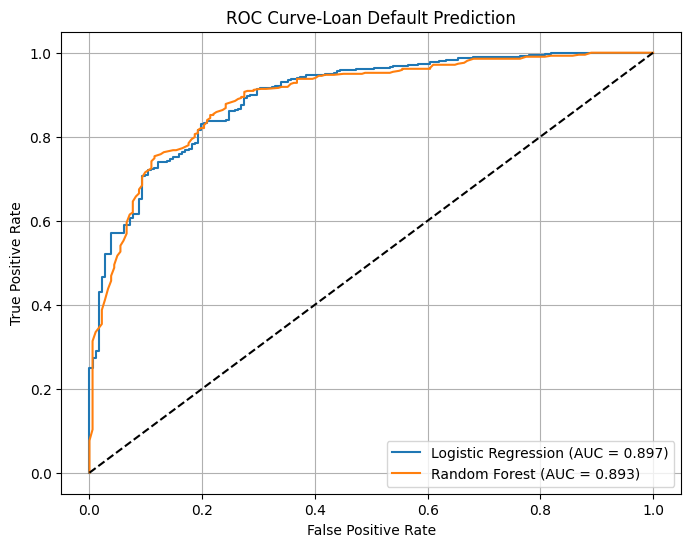

In [7]:
# plot Roc Curve
plt.figure(figsize = (8,6))
for name,model in models.items():
    y_prob = model.predict_proba(x_test)[:,1]
    fpr,tpr, _ = roc_curve(y_test,y_prob)
    auc = roc_auc_score(y_test,y_prob)
    plt.plot(fpr,tpr,label = f"{name} (AUC = {auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve-Loan Default Prediction')
plt.legend()
plt.grid(True)
plt.show()

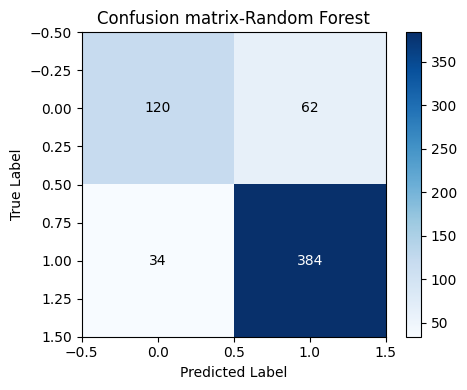

In [8]:
# confusion matrix(random forest)
cm = results['Random Forest']['cm']
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
plt.title('Confusion matrix-Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.colorbar()

for i in range (cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j,i,format(cm[i,j]),
        ha = "center", va = "center",
        color = "white" if cm[i,j] > cm.max()/2 else "black")
plt.tight_layout()
plt.show()

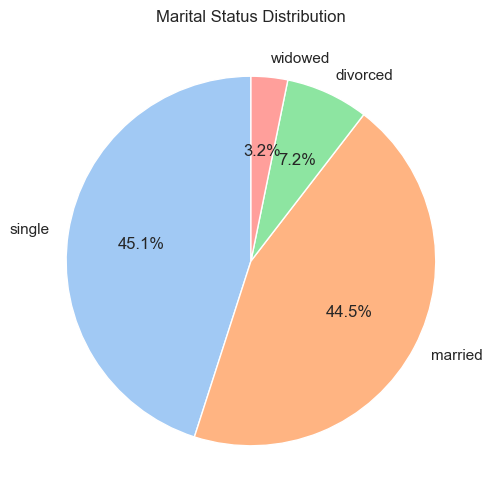

In [9]:
# Columns: ['age', 'income', 'loan_amount', 'loan_term_month', 'credit_score', 
#           'employment_years', 'marital_status', 'purpose', 'default']

# Set Seaborn style
sns.set(style="whitegrid")

# ---------- 1. PIE CHART ----------
# Distribution of marital status
plt.figure(figsize=(6,6))
df['marital_status'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Marital Status Distribution')
plt.ylabel('')
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_46032\1776983157.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='purpose', data=df, palette='Set2')


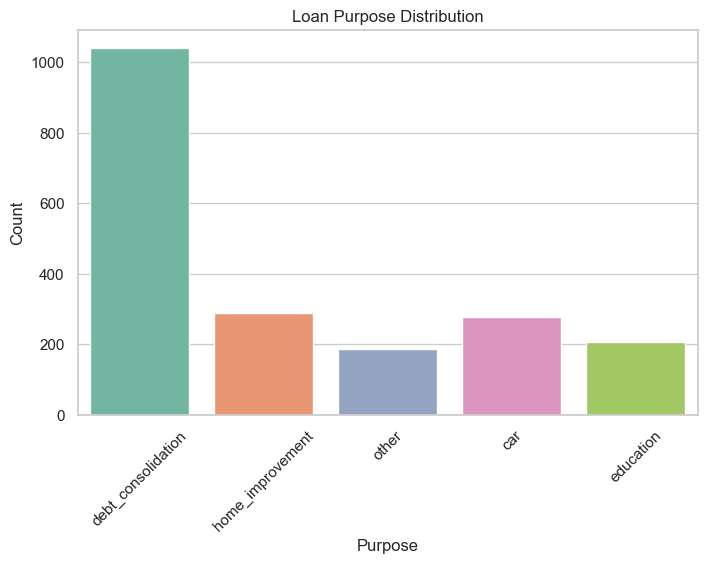

In [10]:
# ---------- 2. BAR PLOT ----------
# Count of loan purpose categories
plt.figure(figsize=(8,5))
sns.countplot(x='purpose', data=df, palette='Set2')
plt.title('Loan Purpose Distribution')
plt.xlabel('Purpose')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

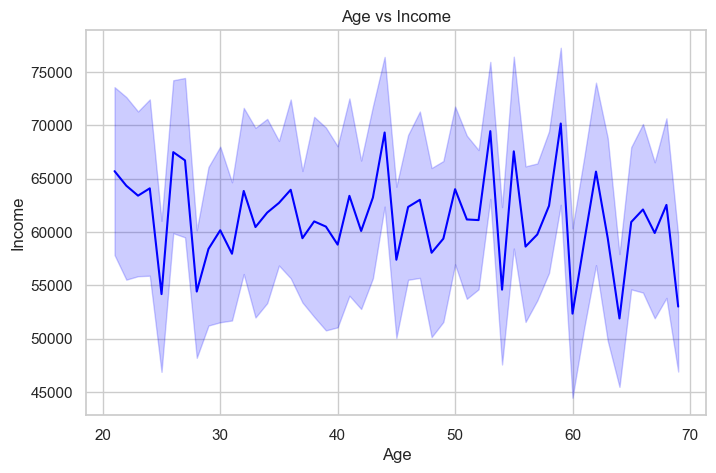

In [11]:
# ---------- 3. LINE CHART ----------
# Relationship between age and income
plt.figure(figsize=(8,5))
sns.lineplot(x='age', y='income', data=df, color='blue')
plt.title('Age vs Income')
plt.xlabel('Age')
plt.ylabel('Income')
plt.show()


C:\Users\Dell\AppData\Local\Temp\ipykernel_46032\3704859049.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='marital_status', y='credit_score', data=df, palette='coolwarm')


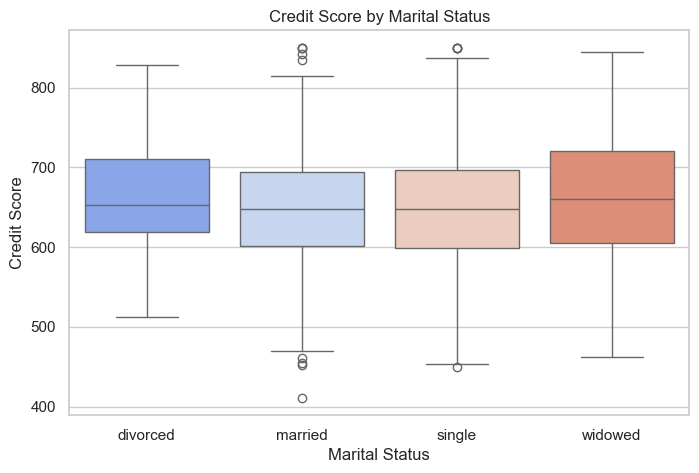

In [12]:
# ---------- 4. BOX PLOT ----------
# Compare credit score by marital status
plt.figure(figsize=(8,5))
sns.boxplot(x='marital_status', y='credit_score', data=df, palette='coolwarm')
plt.title('Credit Score by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Credit Score')
plt.show()

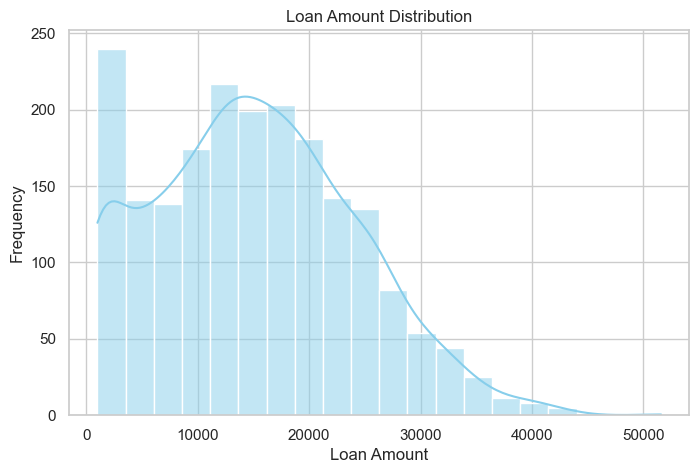

In [13]:
# ---------- 5. HISTOGRAM ----------
# Distribution of loan amounts
plt.figure(figsize=(8,5))
sns.histplot(df['loan_amount'], bins=20, kde=True, color='skyblue')
plt.title('Loan Amount Distribution')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show()
